## viz the data

In [1]:
import os

fname = os.path.join("./data/jena_climate/jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [2]:
import numpy as np

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

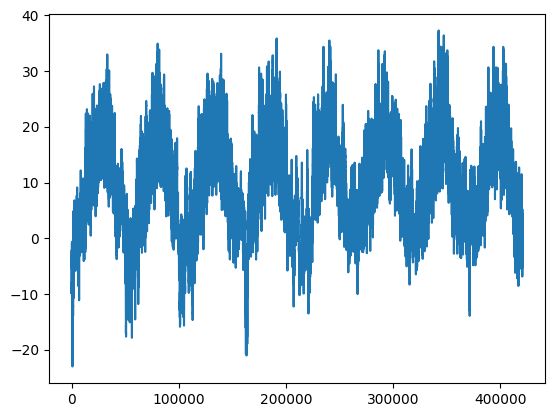

In [3]:
from matplotlib import pyplot as plt

plt.plot(range(len(temperature)), temperature)

### Plotting the first 10 days of the temperature timeseries

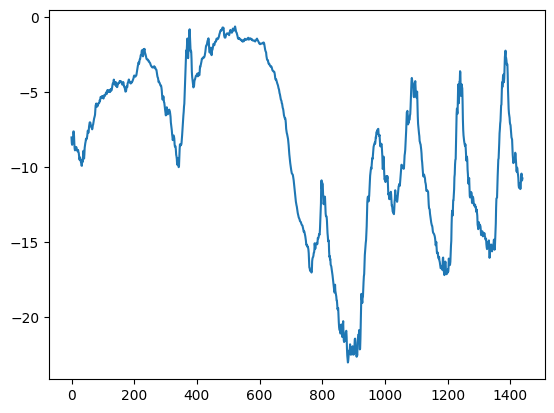

In [4]:
plt.plot(range(1440), temperature[:1440])

In [5]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


## Preparing the data

In [6]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

`timeseries_dataset_from_array` api

In [7]:
import numpy as np
from tensorflow import keras

int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

Metal device set to: Apple M1 Max
[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


2023-02-07 23:23:34.817405: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-07 23:23:34.817529: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-07 23:23:34.866677: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


### Instantiating datasets for training, validation, and testing

In [8]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples,
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples,
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples,
)

In [9]:
for samples, targets in train_dataset:
    # batch_size x time_series_length x features
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


## A common-sense, non-machine-learning baseline

In [10]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.0
    samples_seen = 0
    for samples, targets in dataset:
        #
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen


print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


## Let's try a basic machine-learning model

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks
)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10


2023-02-07 23:23:42.261118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


817/819 [============================>.] - ETA: 0s - loss: 13.6211 - mae: 2.8536

2023-02-07 23:23:50.659313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


819/819 [==============================] - 12s 15ms/step - loss: 13.6129 - mae: 2.8526 - val_loss: 12.9068 - val_mae: 2.8335
Epoch 2/10
819/819 [==============================] - 12s 14ms/step - loss: 9.4707 - mae: 2.4162 - val_loss: 11.3502 - val_mae: 2.6548
Epoch 3/10
819/819 [==============================] - 13s 15ms/step - loss: 8.5672 - mae: 2.3020 - val_loss: 10.6114 - val_mae: 2.5691
Epoch 4/10
819/819 [==============================] - 13s 16ms/step - loss: 8.0308 - mae: 2.2296 - val_loss: 10.7025 - val_mae: 2.5765
Epoch 5/10
819/819 [==============================] - 13s 16ms/step - loss: 7.6964 - mae: 2.1841 - val_loss: 10.4796 - val_mae: 2.5558
Epoch 6/10
819/819 [==============================] - 13s 16ms/step - loss: 7.4153 - mae: 2.1438 - val_loss: 12.7988 - val_mae: 2.8312
Epoch 7/10
819/819 [==============================] - 13s 16ms/step - loss: 7.1928 - mae: 2.1148 - val_loss: 10.4712 - val_mae: 2.5571
Epoch 8/10
819/819 [==============================] - 13s 16ms/st

2023-02-07 23:25:49.722914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


405/405 [==============================] - 5s 11ms/step - loss: 11.4620 - mae: 2.6831
Test MAE: 2.68


In [12]:
import matplotlib.pyplot as plt


def viz_history(history):
    loss = history.history["mae"]
    val_loss = history.history["val_mae"]
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, "bo", label="Training MAE")
    plt.plot(epochs, val_loss, "b", label="Validation MAE")
    plt.title("Training and validation MAE")
    plt.legend()
    plt.show()

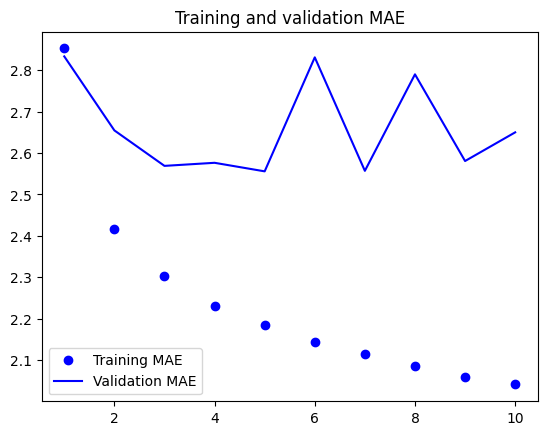

In [13]:
viz_history(history)

## Let's try a 1D convolutional model

In [14]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("jena_conv.keras", save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks
)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10


2023-02-07 23:25:54.584674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


819/819 [==============================] - ETA: 0s - loss: 22.2778 - mae: 3.6945

2023-02-07 23:26:04.530289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


819/819 [==============================] - 14s 17ms/step - loss: 22.2778 - mae: 3.6945 - val_loss: 15.7638 - val_mae: 3.1109
Epoch 2/10
819/819 [==============================] - 13s 16ms/step - loss: 15.2688 - mae: 3.1113 - val_loss: 16.7416 - val_mae: 3.2097
Epoch 3/10
819/819 [==============================] - 13s 16ms/step - loss: 14.0369 - mae: 2.9821 - val_loss: 14.9545 - val_mae: 3.0706
Epoch 4/10
819/819 [==============================] - 13s 16ms/step - loss: 13.1668 - mae: 2.8836 - val_loss: 17.9822 - val_mae: 3.3995
Epoch 5/10
819/819 [==============================] - 14s 17ms/step - loss: 12.5408 - mae: 2.8100 - val_loss: 15.4307 - val_mae: 3.1263
Epoch 6/10
819/819 [==============================] - 13s 16ms/step - loss: 12.0224 - mae: 2.7486 - val_loss: 17.3306 - val_mae: 3.2997
Epoch 7/10
819/819 [==============================] - 13s 16ms/step - loss: 11.5727 - mae: 2.6931 - val_loss: 16.0491 - val_mae: 3.1810
Epoch 8/10
819/819 [==============================] - 15s 1

2023-02-07 23:28:09.597215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


405/405 [==============================] - 4s 10ms/step - loss: 15.9861 - mae: 3.1745
Test MAE: 3.17


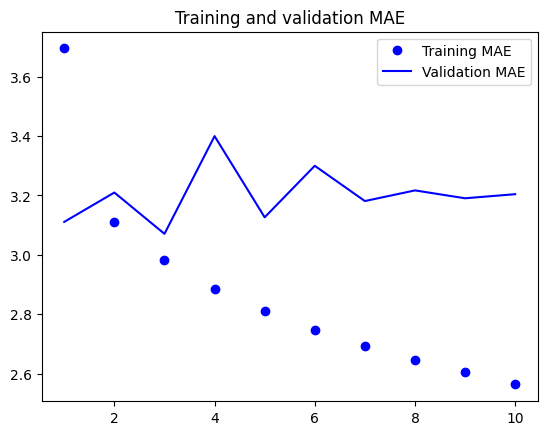

In [15]:
viz_history(history)

## A first recurrent baseline

In [16]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks
)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10


2023-02-07 23:28:14.478539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-07 23:28:14.670738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-07 23:28:14.872509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


819/819 [==============================] - ETA: 0s - loss: 43.1354 - mae: 4.7833

2023-02-07 23:28:40.571913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-07 23:28:40.705167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


819/819 [==============================] - 34s 41ms/step - loss: 43.1354 - mae: 4.7833 - val_loss: 13.0637 - val_mae: 2.7501
Epoch 2/10
819/819 [==============================] - 33s 40ms/step - loss: 11.0550 - mae: 2.5845 - val_loss: 9.8571 - val_mae: 2.4362
Epoch 3/10
819/819 [==============================] - 31s 38ms/step - loss: 9.7748 - mae: 2.4379 - val_loss: 9.7627 - val_mae: 2.4362
Epoch 4/10
819/819 [==============================] - 31s 38ms/step - loss: 9.2702 - mae: 2.3746 - val_loss: 9.7333 - val_mae: 2.4246
Epoch 5/10
819/819 [==============================] - 33s 40ms/step - loss: 8.9238 - mae: 2.3294 - val_loss: 9.9527 - val_mae: 2.4470
Epoch 6/10
819/819 [==============================] - 32s 39ms/step - loss: 8.6388 - mae: 2.2941 - val_loss: 9.7232 - val_mae: 2.4201
Epoch 7/10
819/819 [==============================] - 32s 39ms/step - loss: 8.3784 - mae: 2.2608 - val_loss: 9.8951 - val_mae: 2.4414
Epoch 8/10
819/819 [==============================] - 32s 39ms/step - 

2023-02-07 23:33:35.799647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-07 23:33:35.924982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


405/405 [==============================] - 8s 20ms/step - loss: 10.7401 - mae: 2.5698
Test MAE: 2.57


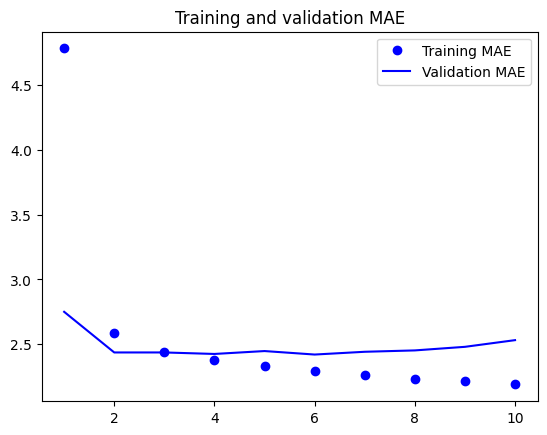

In [17]:
viz_history(history)

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

In [18]:
# too slow to train on m1 max
# inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# x = layers.LSTM(32, recurrent_dropout=0.25, unroll=True)(inputs)
# x = layers.Dropout(0.5)(x)
# outputs = layers.Dense(1)(x)
# model = keras.Model(inputs, outputs)

# callbacks = [
#     keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras", save_best_only=True)
# ]
# model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
# history = model.fit(
#     train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks
# )